## Importing and cleaning data

In [49]:
import pandas as pd
import numpy as np
import re
 
transaction_history_1 = pd.read_csv("../transaction_history_csv/sep-dec.csv")
transaction_history_2 = pd.read_csv("../transaction_history_csv/jun-sep.csv")
transaction_history = pd.concat([transaction_history_1, transaction_history_2])

# transaction_history = transaction_history[transaction_history["Reference"] == "UMC-S"]
transaction_history["Transaction Date"] = pd.to_datetime(transaction_history["Transaction Date"])
transaction_history["Debit Amount"] = transaction_history["Debit Amount"].replace({' ': np.nan})
transaction_history["Debit Amount"] = transaction_history["Debit Amount"].astype(float)
transaction_history["Date"] = transaction_history["Transaction Date"].dt.strftime('%b %d')
transaction_history["Month"] = transaction_history["Transaction Date"].dt.strftime('%m %b')
transaction_history["Vendor"] = transaction_history["Transaction Ref1"].fillna(transaction_history["Transaction Ref2"])

transaction_history

,Transaction Date,Reference,Debit Amount,Credit Amount,Transaction Ref1,Transaction Ref2,Transaction Ref3,Unnamed: 7,Date,Month,Vendor
0,2024-12-01,UMC-S,41.99,,NaN,COTTON ON SINGAPORE PT SI NG 30NOV,5264-7110-0390-7302,NaN,Dec 01,12 Dec,COTTON ON SINGAPORE PT SI NG 30NOV
1,2024-12-01,UMC-S,16.38,,NaN,BUS/MRT 542846245 SI NG 22NOV,5264-7110-0390-7302,NaN,Dec 01,12 Dec,BUS/MRT 542846245 SI NG 22NOV
2,2024-11-29,UMC-S,22.40,,MCDONALD'S (PS) SI NG 25NOV,5264-7110-0390-7302,NaN,NaN,Nov 29,11 Nov,MCDONALD'S (PS) SI NG 25NOV
3,2024-11-28,UMC-S,22.80,,EAT 3 BOWLS SI NG 26NOV,5264-7110-0390-7302,NaN,NaN,Nov 28,11 Nov,EAT 3 BOWLS SI NG 26NOV
4,2024-11-27,UMC-S,4.60,,MCDONALDS 930201 SI NG 26NOV,5264-7110-0390-7302,NaN,NaN,Nov 27,11 Nov,MCDONALDS 930201 SI NG 26NOV
...,...,...,...,...,...,...,...,...,...,...,...
108,2024-06-13,UMC-S,13.21,,BUS/MRT 449978088 SI NG 04JUN,5264-7110-1009-8095,NaN,NaN,Jun 13,06 Jun,BUS/MRT 449978088 SI NG 04JUN
109,2024-06-09,UMC-S,10.90,,POPEYES - THE SELETAR SI NG 31MAY,5264-7110-1009-8095,NaN,NaN,Jun 09,06 Jun,POPEYES - THE SELETAR SI NG 31MAY
110,2024-06-08,UMC-S,10.80,,BUS/MRT 447292638 SI NG 30MAY,5264-7110-1009-8095,NaN,NaN,Jun 08,06 Jun,BUS/MRT 447292638 SI NG 30MAY
111,2024-06-06,ICT,21.00,,PayNow Transfer 8688249,To: Yuta,OTHR PayNow Transfer,NaN,Jun 06,06 Jun,PayNow Transfer 8688249


## Categorizing vendors

In [50]:
test_dict = {
    'a': [1,2,3],
    'b': [4,5,6],
    'c': [7,8,9]
}

for key, value in test_dict.items():
    print(key, value)

a [1, 2, 3]
b [4, 5, 6]
c [7, 8, 9]


In [70]:
def remove_special_characters(string):
    return "".join(e for e in string.lower() if e.isalnum())

def check_if_string_in_list(original_string, reference_list):
    if not isinstance(original_string, str):
        return False
    original_list = [remove_special_characters(s) for s in re.split("\\s+|\.|\@|\*|\/|\_|\-", original_string)]
    return any([x in reference_list for x in original_list])

def categorize_vendors(original_string, reference_dict):
    if not isinstance(original_string, str):
        return "Others"
    original_list = [remove_special_characters(s) for s in re.split("\\s+|\.|\@|\*|\/|\_|\-", original_string)]
    for x in original_list:
        for key, value in reference_dict.items():
            if x in value:
                return key
    return "Shopping"

# F&B vendors list
with open("../restaurants.txt") as restaurants:
    lines = restaurants.readlines()

    restaurant_list = []
    for line in lines:
        line = [remove_special_characters(e) for e in line.split(", ")]
        restaurant_list.extend(line)

    restaurant_list = list(set(restaurant_list))

# Transport vendors list
# Transport, transfers, salary, and medical lists
transport_list = ["bus", "grab"]
transfer_list = ["paynow", "transfer", "ref", "bank", "revolut"]
salary_list = ["mindef", "saf"]
medical_list = ["polyclinic", "clinic"]

# Vendor group dictionary
vendor_groups = {
    "F&B": restaurant_list,
    "Transport": transport_list,
    "Transfers": transfer_list,
    "Salary": salary_list,
    "Medical": medical_list
}

# Transportation vendors list
transaction_history["Category"] = transaction_history["Vendor"].apply(lambda x: categorize_vendors(x, vendor_groups))
output_directory = "../transaction_history_csv/out.csv"
transaction_history["Category"].value_counts()

Category
Shopping     98
Transfers    98
F&B          75
Transport    53
Salary        5
Others        3
Medical       1
Name: count, dtype: int64

In [71]:
def plot_debit_amount(df):
    df[["Transaction Date", "Debit Amount"]].set_index("Transaction Date").plot.line()

def plot_monthly_debit_spending(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").sum().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def plot_spending_histogram(df, bins_count=100):
    df["Debit Amount"].plot.hist(bins=bins_count)

def plot_number_of_transactions_monthly(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").count().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def get_price_range(df, upper, lower=-np.inf):
    return df[(df["Debit Amount"] < upper) & (df["Debit Amount"] > lower)] 

def get_category(df, category):
    return df[df["Category"]==category]

def output_csv(df, directory):
    df.to_csv(directory, index=False)


In [73]:
output_csv(get_category(transaction_history, "Shopping")[["Transaction Date", "Vendor", "Debit Amount", "Category"]], output_directory)

## Total spending over time

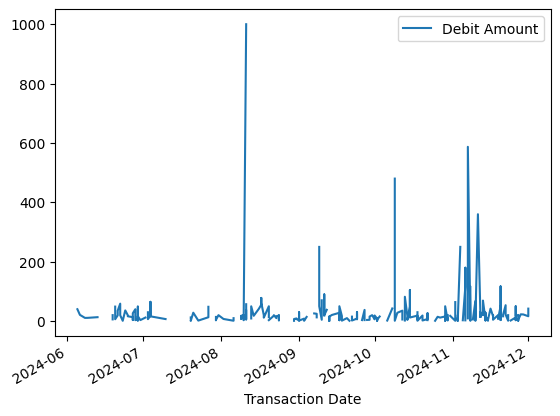

In [75]:
plot_debit_amount(transaction_history)

## Spending on F&B over time

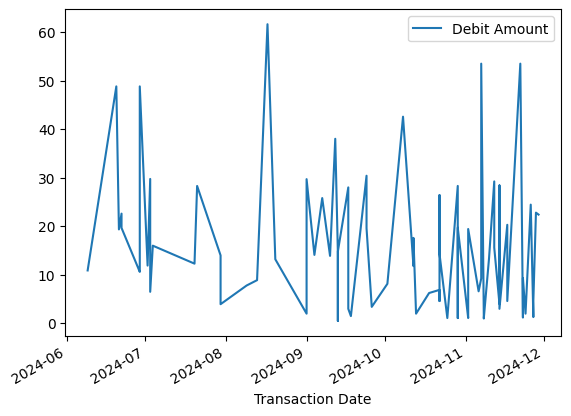

In [55]:
plot_debit_amount(get_category(transaction_history, "F&B"))

## Histogram of total spending

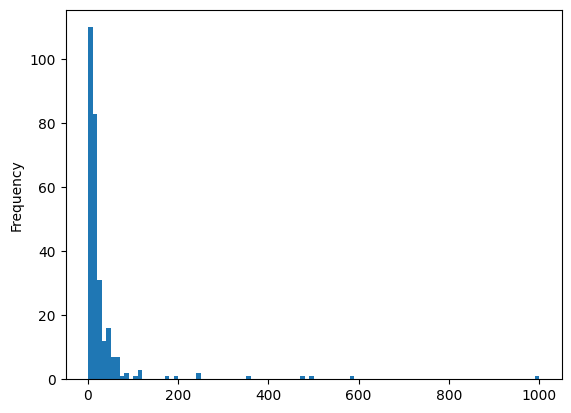

In [56]:
plot_spending_histogram(transaction_history)

## Histogram of spending on F&B

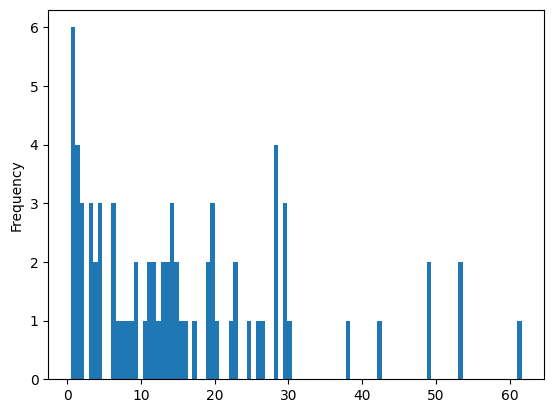

In [57]:
plot_spending_histogram(get_category(transaction_history, "F&B"))

## Monthly spending 

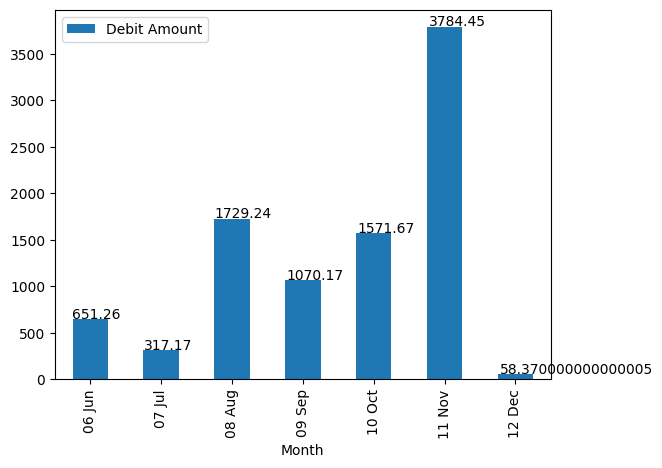

In [58]:
plot_monthly_debit_spending(transaction_history)

## Monthly F&B spending

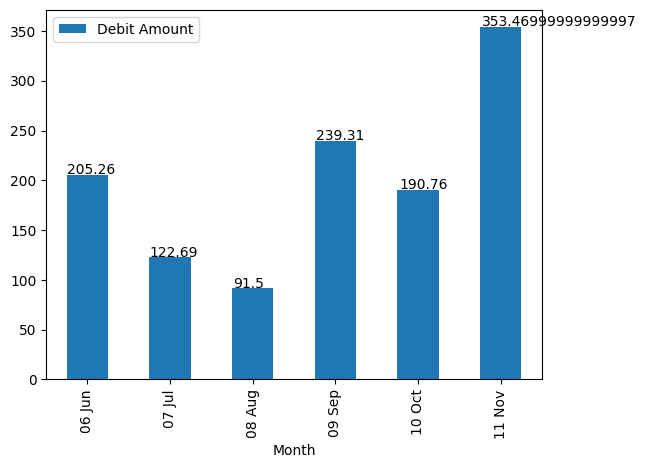

In [59]:
plot_monthly_debit_spending(get_category(transaction_history, "F&B"))

## Monthly total count of transactions

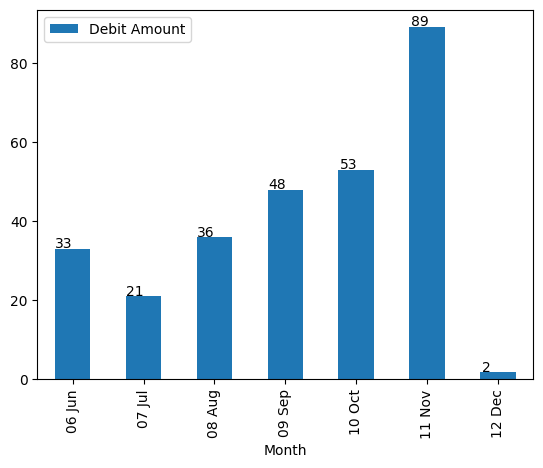

In [60]:
plot_number_of_transactions_monthly(transaction_history)

## Monthly count of transactions on F&B

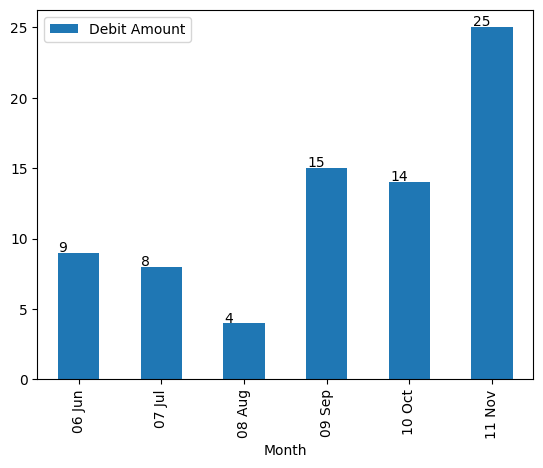

In [61]:
plot_number_of_transactions_monthly(get_category(transaction_history, "F&B"))

## Price bands

In [62]:
df = get_category(transaction_history, "Others")

price_bands = {
    "0-10": float(get_price_range(df, 10)["Debit Amount"].sum()),
    "10-20": float(get_price_range(df, 20, 10)["Debit Amount"].sum()),
    "20-30": float(get_price_range(df, 30, 20)["Debit Amount"].sum()),
    "30-40": float(get_price_range(df, 40, 30)["Debit Amount"].sum()),
    "40-50": float(get_price_range(df, 50, 40)["Debit Amount"].sum()),
    "50+": float(get_price_range(df, np.inf, 50)["Debit Amount"].sum())
}

price_bands

{'0-10': 141.06,
 '10-20': 341.86,
 '20-30': 157.6,
 '30-40': 180.9,
 '40-50': 271.39,
 '50+': 1208.31}